In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 25

name = 'vei'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [2]:
import os
import wandb
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import seaborn as sns
import torch
from torch import load

from nnfabrik.main import *
from mei.main import MEISeed, MEIMethod
from nnfabrik.main import Dataset, my_nnfabrik
from nnsysident.tables.experiments import TrainedModel, schema
from nnsysident.tables.mei import MEISelector, TrainedEnsembleModel, MEI, MEIMonkey, MEIExperimentsMonkey, MEIExperimentsMouse
from nnvision.tables.main import Recording

device = "cuda"
random_seed = 42

Connecting konstantin@134.76.19.44:3306


___

In [124]:
MEI.progress(MEIExperimentsMouse.Restrictions & 'experiment_name="{}"'.format("Post-optimization of CEIs (0.8) created with different L1 weights"),)

MEI                  Completed 925 of 1000 (92.5%)   2023-08-23 22:40:02


(75, 1000)

In [65]:
(schema.jobs & "status='error'").delete()

In [86]:
schema.jobs

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp


___

In [7]:
old = pd.DataFrame((TrainedModel() & "dataset_hash = 'd4869853a4fd946b12adf99b70f9f1cf'" & "model_hash = 'c5e4a7ae50f49da6fdff0fb2bce18228'").fetch(as_dict=True))
new = pd.DataFrame((TrainedModel() & "dataset_hash = '9a0e27627452efcb94aed97825771e23'" & "model_hash = 'c5e4a7ae50f49da6fdff0fb2bce18228'").fetch(as_dict=True))
new_lurz = pd.DataFrame((TrainedModel() & "dataset_hash = '9a0e27627452efcb94aed97825771e23'" & "model_hash = '49503eacc668e8950bcc3414e1d623d7'").fetch(as_dict=True))

old = old[["seed", "train_loss", "validation_loss", "test_loss", "train_correlation", "validation_correlation", "test_correlation"]].sort_values("validation_loss")
new = new[["seed", "train_loss", "validation_loss", "test_loss", "train_correlation", "validation_correlation", "test_correlation"]].sort_values("validation_loss")
new_lurz = new_lurz[["seed", "train_loss", "validation_loss", "test_loss", "train_correlation", "validation_correlation", "test_correlation"]].sort_values("validation_loss")

In [21]:
key = dj.AndList(["dataset_fn = 'nnsysident.datasets.mouse_loaders.static_loaders'",
         "dataset_hash = '9a0e27627452efcb94aed97825771e23'",
         "model_fn = 'nnsysident.models.models.stacked2d_zig'",
         "model_hash = '49503eacc668e8950bcc3414e1d623d7'",
         "trainer_fn = 'nnsysident.training.trainers.standard_trainer'",
         "trainer_hash = '69601593d387758e9ff6a5bf26dd6739'",
         "seed in (13, 14, 4, 3, 7)"], 
                )
entries = (TrainedModel & key).proj().fetch(as_dict=True)
len(entries)
# TrainedEnsembleModel().create_ensemble(key, "zig models, modulator, shifter, best 5 val loss out of 15 models, UNCORRUPTED Jiakun dataset, Lurz init")

___

In [54]:
experiment_name = "Post-optimization of CEIs (0.8) created with different L1 weights, many neurons"
table = (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'")



df = pd.DataFrame.from_dict((table).fetch(as_dict=True))
df.drop(columns=["experiment_name", "experiment_restriction_ts"], inplace=True)

df["dataset_hash"] = '9a0e27627452efcb94aed97825771e23'
df["ensemble_hash"] = '694b7602e4c885daccccc10991dddded'
restrictions = df.to_dict("records")
print(len(restrictions))

6250


In [56]:
MEIExperimentsMouse().add_entry("Post-optimization of CEIs (0.8) created with different L1 weights, many neurons, UNCORRUPTED Jiakun", 
                                "kklurz",
                                "Optimize CEIs (0.8 MEI) without regularizer from CEIs which had been made with a L1 regularizer, cut the gradient for not needed pixels. No overall norm applied. Many Neurons but less fine grained in L1. Data from Jiakun is not corrupted.",
                                restrictions)

___

In [84]:
(MEIMethod() & "method_comment like '%pixel_tanh_scale%'").fetch("method_config", limit=1)[0]

{'initial': {'path': 'mei.initial.ImageLoader',
  'kwargs': {'mei_type': 'CEI',
   'ref_level': 0.8,
   'l1': 6.3e-05,
   'zero_grad_threshold': 0.08}},
 'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 20.0}},
 'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
  'kwargs': {'sigma': 1}},
 'stopper': {'path': 'mei.stoppers.EarlyStopping',
  'kwargs': {'patience': 20, 'min_iter': 200}},
 'objectives': [{'path': 'mei.objectives.EvaluationObjective',
   'kwargs': {'interval': 10}}],
 'device': 'cuda',
 'mei_class_name': 'CEI',
 'ref_level': 0.8,
 'pixel_tanh_scale': True}

## Check MEI training

100% 1/1 [00:00<00:00,  5.34it/s]


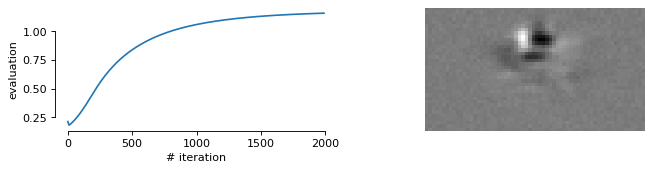

In [8]:
table = (MEI & dj.AndList(["dataset_hash = 'd4869853a4fd946b12adf99b70f9f1cf'", 
             "ensemble_hash = '89233087b4af73dfea4dbca1fbc841d0'", 
             "method_hash = '54f863f93364931f53ecdfe7c2bc5a03'", 
             f"unit_id = {unit_id}"]))

for u_id in tqdm(np.unique(table.fetch("unit_id"))):
    output_path = (table & f"unit_id = {u_id}").fetch1("output")
    output = load(output_path)
    mei = table.load_mei()[0]
    os.remove(output_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 2), dpi=80)
    axes[0].plot(
        output["mei.objectives.EvaluationObjective"]["times"],
        output["mei.objectives.EvaluationObjective"]["values"],
    )
    axes[1].imshow(mei.squeeze(), cmap="gray")
    axes[1].axis("off")

    axes[0].set_xlabel("# iteration")
    axes[0].set_ylabel("evaluation")
    sns.despine(trim=True)

# Inserting tables

#### Create Ensemble Model

In [ ]:
key = dict(dataset_fn="nnvision.datasets.monkey_loaders.monkey_static_loader",
           dataset_hash="075e942fd72e20d77d672d7a942ebc61",
           # model_fn="nnsysident.models.models.stacked2d_zig",
           model_hash="acca54db77f06e9f37b72900ddc57263",
           trainer_hash="69601593d387758e9ff6a5bf26dd6739")

# TrainedEnsembleModel().create_ensemble(key, comment="Monkey V1 Gamma Model, PointPooled")
TrainedEnsembleModel()

#### Populate Selector Table

In [188]:
TrainedEnsembleModel() & "ensemble_hash = '89233087b4af73dfea4dbca1fbc841d0'"

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,ensemble_hash the hash of the ensemble,ensemble_comment a short comment describing the ensemble
nnsysident.datasets.mouse_loaders.static_loaders,d4869853a4fd946b12adf99b70f9f1cf,89233087b4af73dfea4dbca1fbc841d0,"zig models, modulator, shifter, best 5 val loss out of 15 models, Jiakun dataset"


In [37]:
restr = "dataset_hash = '9a0e27627452efcb94aed97825771e23'"
MEISelector.populate(restr)
MEISelector() & restr

dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,unit_id unique neuron identifier,data_key unique session identifier,unit_index integer position of the neuron in the model's output
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,1,27940-2-13-0,0
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,3,27940-2-13-0,1
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,4,27940-2-13-0,2
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,5,27940-2-13-0,3
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,6,27940-2-13-0,4
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,7,27940-2-13-0,5
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,8,27940-2-13-0,6
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,9,27940-2-13-0,7
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,10,27940-2-13-0,8
nnsysident.datasets.mouse_loaders.static_loaders,9a0e27627452efcb94aed97825771e23,11,27940-2-13-0,9


#### Specify MEI Method Parameters

In [6]:
method_fn = "mei.methods.gradient_ascent"
for l1 in np.arange(0.000001, 0.0001, 0.000001):
    l1 = round(l1, 6)
    method_config = {'initial': {'path': 'mei.initial.ImageLoader', 'kwargs': {"mei_type": "CEI", "ref_level": 0.8, "l1": l1, "zero_grad_threshold": .08}},
                     'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 20.}},
                     'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
                      'kwargs': {'sigma': 1}},
                     'stopper': {'path': 'mei.stoppers.EarlyStopping',
                      'kwargs': {'patience': 20, "min_iter": 200}},
                     'objectives': [{'path': 'mei.objectives.EvaluationObjective',
                       'kwargs': {'interval': 10}}],
                     'device': 'cuda',
                     'mei_class_name': 'CEI',
                     'ref_level': 0.8,
                     'pixel_tanh_scale': True,
                     }
    method_comment = f"CEI, 0.8, l1_init: {l1}, NoNorm, pixel_tanh_scale"
    MEIMethod().add_method(method_fn, method_config, comment=method_comment)


In [56]:
method_fn = "mei.methods.gradient_ascent"

# MEI
# method_config = {'initial': {'path': 'mei.initial.RandomNormal'},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 0.2}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                   'kwargs': {'sigma': 1}},
#                  'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
#                   'kwargs': {'norm': 12}},
#                  'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                   'kwargs': {'patience': 20, "min_iter": 200}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                    'kwargs': {'interval': 10}}],
#                  'device': 'cuda',
#                  'mei_class_name': 'MEI'}
# method_comment = "MEI, norm=12"

# CEI
# l1 = 0.0001
# method_config = {'initial': {'path': 'mei.initial.OneValue', 'kwargs': {'fill_value': 0.01}},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 20.}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                   'kwargs': {'sigma': 1}},
#                  'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                   'kwargs': {'patience': 20, "min_iter": 200}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                    'kwargs': {'interval': 10}}],
#                     "regularization": {
#                         "path": 'mei.legacy.ops.L1Norm',
#                         "kwargs": {"weight": l1},
#                     },
#                  'device': 'cuda',
#                  'mei_class_name': 'CEI',
#                  'ref_level': 0.8,
#                  }
# method_comment = f"CEI, 0.8, OneValue, NoNorm, L1: {l1}"

# VEI from CEI
# method_config = {'initial': {'path': 'mei.initial.ImageLoader', 'kwargs': {"mei_type": "CEI", "ref_level": 0.8}},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 0.05}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                   'kwargs': {'sigma': 1}},
#                  'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
#                   'kwargs': {'norm': 10}},
#                  'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                   'kwargs': {'patience': 20, "min_iter": 200}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                    'kwargs': {'interval': 10}}],
#                  'device': 'cuda',
#                  'mei_class_name': 'VEI',
#                  'ref_level': 0.8,
#                  "variance_optimization": "min",
#                  "scale": 100,
#                  "dx": 0.02,
#                  }
# method_comment = "VEI-, 0.8, 0.02"

# VEI from MEI
# method_config = {'initial': {'path': 'mei.initial.ImageLoader', 'kwargs': {"mei_type": "MEI"}},
#                  'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 0.05}},
#                  'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
#                   'kwargs': {'sigma': 1}},
#                  'postprocessing': {'path': 'mei.legacy.ops.ChangeNorm',
#                   'kwargs': {'norm': 10}},
#                  'stopper': {'path': 'mei.stoppers.EarlyStopping',
#                   'kwargs': {'patience': 20, "min_iter": 200}},
#                  'objectives': [{'path': 'mei.objectives.EvaluationObjective',
#                    'kwargs': {'interval': 10}}],
#                  'device': 'cuda',
#                  'mei_class_name': 'VEI',
#                  'ref_level': 1.,
#                  "variance_optimization": "min",
#                  "scale": 100,
#                  "dx": 0.02,
#                  }
# method_comment = "VEI-, 1., 0.02"

# MEIMethod().add_method(method_fn, method_config, comment=method_comment)
# MEIMethod()

# Get good neurons

In [68]:
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.utility.measures import get_oracles

# ensemble_comment = 'gamma models, modulator, shifter'
# ensemble_comment = 'gamma models'
ensemble_comment = 'zig models, modulator, shifter, best 5 val loss out of 15 models, Jiakun dataset'


ensemble_hash, dataset_hash = (TrainedEnsembleModel() & f"ensemble_comment = '{ensemble_comment}'").fetch1("ensemble_hash", "dataset_hash")

dataset_config = (Dataset() & f"dataset_hash = '{dataset_hash}'").fetch1("dataset_config")
dataset_config["return_test_sampler"] = True
dataset_config["tier"] = "test"
dataset_config['loader_outputs'] = ['images', 'responses']
dataset_config['subtract_behavior_mean'] = False

dataloaders = static_loaders(**dataset_config)
oracles = get_oracles(dataloaders["test"])

idx = np.argsort(oracles)
percentile = int(0.1*len(idx))
selected_idx = idx[-percentile:]
unit_ids = (MEISelector() & "unit_index in {}".format(tuple(selected_idx))).fetch("unit_id")[:10]

Returning only test sampler with repeats...


/project/nnsysident/utility/measures.py:257: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(repeated_inputs), np.array(repeated_outputs)


In [8]:
ensemble_comment = 'Monkey V1 Gamma Model, PointPooled'
ensemble_hash = (TrainedEnsembleModel() &
                 f"ensemble_comment = '{ensemble_comment}'").fetch1("ensemble_hash")
monkey_data_key = "3631807112901"
unit_ids = (Recording.Units() & f"data_key = '{monkey_data_key}'").fetch("unit_id")[:10]

In [125]:
print("Correlation:")
print("Poisson: " + str((TrainedModel() & "model_fn like '%poisson%'").fetch("test_correlation").mean()))
print("Gamma: " + str((TrainedModel() & "model_fn like '%gamma%'").fetch("test_correlation").mean()))
print("ZIG: " + str((TrainedModel() & "model_fn like '%zig%'").fetch("test_correlation").mean()))

print("")

print("Loss:")
print("Poisson: " + str((TrainedModel() & "model_fn like '%poisson%'").fetch("test_loss").mean()))
print("Gamma: " + str((TrainedModel() & "model_fn like '%gamma%'").fetch("test_loss").mean()))
print("ZIG: " + str((TrainedModel() & "model_fn like '%zig%'").fetch("test_loss").mean()))

Correlation:
Poisson: 0.27654999999999996
Gamma: 0.3103102
ZIG: 0.2747288

Loss:
Poisson: 0.7987650000000001
Gamma: -7.092728666666668
ZIG: -8.060051999999999


## Code for designing experiments

In [3]:
key = dj.AndList(["dataset_fn = 'nnsysident.datasets.mouse_loaders.static_loaders'",
         "dataset_hash = '77fecfed4eaa33736d47244f2c14b36b'",
         "model_fn = 'nnsysident.models.models.stacked2d_gamma'",
         "model_hash = 'ea7c8ee30c9f5ab0a632392c3a4b32c0'",
         "trainer_fn = 'nnsysident.training.trainers.standard_trainer'",
         "trainer_hash = '69601593d387758e9ff6a5bf26dd6739'",
         "seed in (6, 7, 8, 9, 10)"])
entries = (TrainedModel & key).proj().fetch(as_dict=True)
len(entries)
TrainedEnsembleModel().create_ensemble(entries, comment="gamma models, modulator, shifter, alternative ensemble0", skip_duplicates=True)

In [123]:
entries = (MEIExperimentsMouse().Restrictions()  & "experiment_name = 'Mouse V1, mu=0.8, gamma models, modulator, shifter, Zhiwei0'").proj().fetch(as_dict=True)
for entry in entries:
    entry["ensemble_hash"] = "c2c201b30ede9f7df271d45d78ba27cd"
    del entry["experiment_name"]
    # entry["data_key"] = "26614-1-16-0"
    # entry["dataset_hash"] = "2ea3ee9f182eace63e8598e029ca94a3"
    if entry["method_hash"] == "06d3810135ef79811be0c8b7bcae9482":
        entry["method_hash"] = "f36b2ca6ab7b71e91ad190192b7da9ea"

In [56]:
all_entries = []
for entry in entries:
    
    for unit_id in [1056, 3853, 1673, 2102, 6831, 4794, 6816, 6362, 5132]:
        x = entry.copy()
        x["unit_id"] = unit_id
        all_entries.append(x)

In [126]:
MEIExperimentsMouse().add_entry('Zhiwei0, alternative ensemble, OneValue init', 
                                "kklurz",
                                "MEI, CEI, VEI+, VEI- for Mouse V1 with 0.8 MEI activation, gamma models with modulator and shifter, dataset from Zhiwei, alternative ensemble0, OneValue init",
                                entries)

In [180]:
keys = [ 'dataset_fn',
 'dataset_hash',
 'ensemble_hash',
 'method_fn',
 'method_hash',
 'unit_id',
 'data_key']
entries = (MEIExperimentsMouse().Restrictions() & "experiment_name = 'Mouse V1, mu=0.8, gamma models'").proj().fetch(*keys, as_dict=True)
restrictions = []
for entry in entries:
    new_entry = entry.copy()
    new_entry["ensemble_hash"] = 'd2afd0862079b312683842967c4f9446'
    restrictions.append(new_entry)
# MEIExperimentsMouse().add_entry("Mouse V1, mu=0.8, poisson models", "kklurz", "MEI, CEI, VEI+, VEI- for Mouse V1 with 0.8 MEI activation, gamma models", restrictions, skip_duplicates=True)

___

In [17]:
table = pd.DataFrame((MEIExperimentsMouse.Restrictions & 'experiment_name="{}"'.format("Different L1 weights, CEI (0.8)")).proj().fetch(as_dict=True)).drop(columns="experiment_name")

old_hashes = table["method_hash"].unique()
method_hashes = (MEIMethod & "method_comment like '%CEI, 0.8, l1_init:%'").fetch("method_hash")

table.replace(old_hashes, method_hashes, inplace=True)
restrictions = table.to_dict("records")

In [15]:
unique_dict = {}
for col in table.columns:
    unique_dict[col] = np.unique(table[col])

In [18]:
MEIExperimentsMouse().add_entry("Post-optimization of CEIs (0.8) created with different L1 weights", 
                                "kklurz",
                                "Optimize CEIs (0.8 MEI) without regularizer from CEIs which had been made with a L1 regularizer, cut the gradient for not needed pixels. No overall norm applied",
                                restrictions)

### Populate MEIs

In [ ]:
unit_ids = np.sort((((Dataset & "dataset_hash = 'd4869853a4fd946b12adf99b70f9f1cf'")) * MEISelector).fetch("unit_id"))[:250]
MEI.populate("method_hash = '54f863f93364931f53ecdfe7c2bc5a03'",
             "dataset_hash = 'd4869853a4fd946b12adf99b70f9f1cf'",
             "unit_id in {}".format(tuple(unit_ids)),
             "ensemble_hash = '89233087b4af73dfea4dbca1fbc841d0'", reserve_jobs=True)

### Different L1 experiment

In [153]:
def extract_l1(dictionary):
    l1 = dictionary["regularization"]["kwargs"]["weight"]
    return l1

In [287]:
experiment_name = "Different L1 weights, CEI (0.8)" #"Post-optimization of CEIs (0.8) created with different L1 weights"
table = (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'" & "unit_id=32")

df = pd.DataFrame.from_dict((MEIMethod & table).fetch(as_dict=True))
df["l1"] = df["method_config"].apply(lambda x: pd.Series(extract_l1(x)))
df = df.loc[df["l1"] <= 5e-5].sort_values("l1").reset_index(drop=True).iloc[::2]

In [288]:
aa = pd.DataFrame.from_dict((table & "method_hash in {}".format(tuple(df["method_hash"]))).fetch(as_dict=True))
aa.drop(columns=["experiment_name", "experiment_restriction_ts"], inplace=True)

restrictions = []
for unit_id in unit_ids:
    aa["unit_id"] = unit_id
    restrictions += aa.to_dict("records")

In [289]:
MEIExperimentsMouse().add_entry("Different L1 weights, CEI (0.8), many neurons", 
                                "kklurz",
                                "Change the size of the CEI (0.8 MEI) using different weights of L1 regularizer. No overall norm applied. Many Neurons but less fine grained in L1",
                                restrictions)

### Post-optimization of different L1 experiment

In [295]:
def extract_l1(dictionary):
    l1 = dictionary["initial"]["kwargs"]["l1"]
    return l1

In [296]:
experiment_name = "Post-optimization of CEIs (0.8) created with different L1 weights"
table = (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'" & "unit_id=32")

df = pd.DataFrame.from_dict((MEIMethod & table).fetch(as_dict=True))
df["l1"] = df["method_config"].apply(lambda x: pd.Series(extract_l1(x)))
df = df.loc[df["l1"] <= 5e-5].sort_values("l1").reset_index(drop=True).iloc[::2]

In [298]:
aa = pd.DataFrame.from_dict((table & "method_hash in {}".format(tuple(df["method_hash"]))).fetch(as_dict=True))
aa.drop(columns=["experiment_name", "experiment_restriction_ts"], inplace=True)

restrictions = []
for unit_id in unit_ids:
    aa["unit_id"] = unit_id
    restrictions += aa.to_dict("records")

In [301]:
MEIExperimentsMouse().add_entry("Post-optimization of CEIs (0.8) created with different L1 weights, many neurons", 
                                "kklurz",
                                "Optimize CEIs (0.8 MEI) without regularizer from CEIs which had been made with a L1 regularizer, cut the gradient for not needed pixels. No overall norm applied. Many Neurons but less fine grained in L1",
                                restrictions)

___

In [20]:
experiment_name = "Post-optimization of CEIs (0.8) created with different L1 weights"
table = (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'")

df = pd.DataFrame.from_dict((table).fetch(as_dict=True))
df.drop(columns=["experiment_name", "experiment_restriction_ts"], inplace=True)

new_hashes = (MEIMethod & "method_comment like '%pixel%'").fetch("method_hash")
old_hashes = df["method_hash"].unique()
df.replace(old_hashes, new_hashes, inplace=True)
restrictions = df.to_dict("records")

In [ ]:
MEIExperimentsMouse().add_entry("Post-optimization of CEIs (0.8) created with different L1 weights, pixel_tanh_scale", 
                                "kklurz",
                                "Optimize CEIs (0.8 MEI) without regularizer from CEIs which had been made with a L1 regularizer, cut the gradient for not needed pixels. Use a pixel_tanh_scale. No overall norm applied.",
                                restrictions)

___

## Tanh on pixels

In [64]:
key = dict(dataset_fn = "nnsysident.datasets.mouse_loaders.static_loaders",
                 dataset_hash = "9a0e27627452efcb94aed97825771e23",
                 ensemble_hash = '694b7602e4c885daccccc10991dddded',
                 unit_id = 101)
dataloaders, model = MEI().model_loader.load(key=key)
seed = random_seed
output_selected_model = MEI().selector_table().get_output_selected_model(model, key)
MEI().add_params_to_model(output_selected_model, key)

/usr/local/lib/python3.9/dist-packages/datajoint/connection.py:219: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:125: UserWarning: The default of `independent_bn_bias=True` will ignore the kwargs `bias`, `batch_norm_scale`, and `final_batchnorm_scale` when initializing the batchnorm. If you want to use these arguments, please set `independent_bn_bias=False`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format

Finished adding params to model!


In [24]:
from mei import optimization
max_iter = 2000

method_fn = "mei.methods.gradient_ascent"
method_config = {'initial': {'path': 'mei.initial.ImageLoader', 'kwargs': {'mei_type': 'CEI', 'ref_level': 0.8, 'l1': 0.000001, 'zero_grad_threshold': 0.08}},
                 'optimizer': {'path': 'torch.optim.SGD', 'kwargs': {'lr': 20.0}},
                 'precondition': {'path': 'mei.legacy.ops.GaussianBlur', 'kwargs': {'sigma': 1}},
                 'stopper': {'path': 'mei.stoppers.EarlyStopping', 'kwargs': {'patience': 20, 'min_iter': 200, 'max_iter': max_iter}},
                 'objectives': [{'path': 'mei.objectives.EvaluationObjective','kwargs': {'interval': 10}}],
                 'device': 'cuda',
                 'mei_class_name': 'CEI',
                 'ref_level': 0.8,
                 'pixel_tanh_scale': -.1}

method_fn = MEIMethod().import_func(method_fn)
mei_class_name = method_config.pop("mei_class_name", "MEI")
if mei_class_name == "MEI":
    mei_class = optimization.MEI
elif mei_class_name == "VEI":
    mei_class = optimization.VEI
elif mei_class_name == "CEI":
    mei_class = optimization.CEI
else:
    raise ValueError(f"mei_class_name '{mei_class_name}' not recognized")

In [25]:
mei, score, output, mean, variance = method_fn(dataloaders, output_selected_model, method_config, seed, mei_class=mei_class)

mei = mei.cpu().data.numpy().squeeze()
cei = output_selected_model.cei[0.8][method_config["initial"]["kwargs"]["l1"]].squeeze()
cei_small = output_selected_model.cei[0.8][0.0001]

pixel_tanh_scale is set!
Using a transparency weight of 1.0
Early stopping finished after 420 iterations.
Restoring best state...


In [26]:
for x in [mei, cei]:
    x = torch.from_numpy(x)[None,None, :, :].to(device)

    behavior = torch.zeros((x.shape[0], 3)).to(device) 
    pupil_center = torch.zeros((x.shape[0], 2)).to(device)

    x_mean = output_selected_model.predict_mean(x, behavior=behavior, pupil_center=pupil_center)
    x_variance = output_selected_model.predict_mean(x, behavior=behavior, pupil_center=pupil_center)

    print((x_mean/output_selected_model.mei_mean).item())
    print((x_variance/output_selected_model.mei_variance).item())
    print("___________________________________")

0.7999998927116394
0.30768921971321106
___________________________________
0.7998570203781128
0.30763426423072815
___________________________________


In [27]:
x = torch.Tensor([-.1])
2*torch.sigmoid(x)

tensor([0.9500])

In [41]:
print(mei.max())
print(cei.max())
print(cei_small.max())

0.89796895
1.5868926
2.224487


In [43]:
cut = np.abs(cei_small).max() * method_config["initial"]["kwargs"]["zero_grad_threshold"]
zero_grad_mask = np.abs(cei_small) < cut

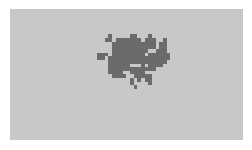

In [45]:
fig, ax = plt.subplots()
ax.imshow(zero_grad_mask, cmap="gray", vmin=vmin, vmax=vmax)
ax.axis("off");

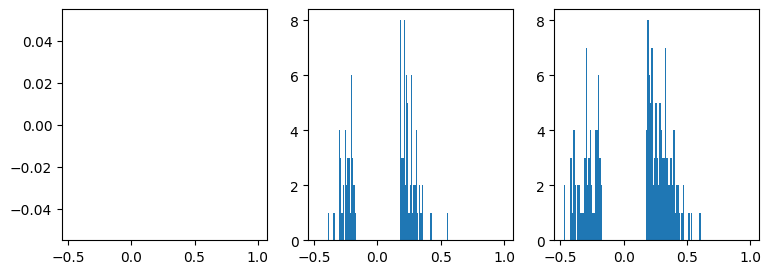

In [63]:
fig, axes = plt.subplots(1,3,dpi=100, figsize=(9,3), sharex=True)
axes[0].hist(cei_small[zero_grad_mask][np.abs(cei_small[zero_grad_mask])>cut], bins=100);
axes[1].hist(cei[zero_grad_mask][np.abs(cei[zero_grad_mask])>cut], bins=100);
axes[2].hist(mei[zero_grad_mask][np.abs(mei[zero_grad_mask])>cut], bins=100);

# sns.despine(trim=True)

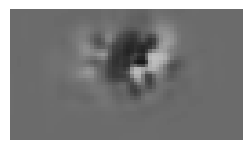

In [31]:
vmin = cei.min()
vmax = cei.max()

fig, ax = plt.subplots()
ax.imshow(mei, cmap="gray", vmin=vmin, vmax=vmax)
ax.axis("off");

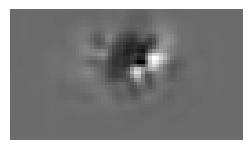

In [32]:
fig, ax = plt.subplots()
ax.imshow(cei, cmap="gray", vmin=vmin, vmax=vmax)
ax.axis("off");

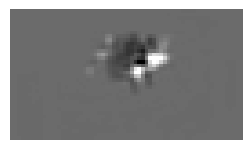

In [39]:
fig, ax = plt.subplots()
ax.imshow(cei_small, cmap="gray", vmin=vmin, vmax=vmax)
ax.axis("off");

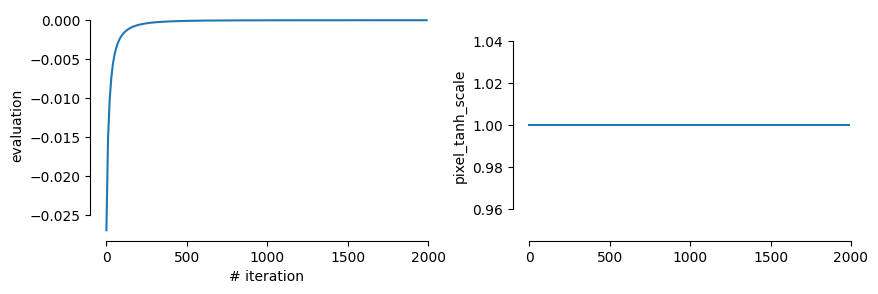

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), dpi=100)
axes[0].plot(
    output["mei.objectives.EvaluationObjective"]["times"],
    output["mei.objectives.EvaluationObjective"]["values"],
)
axes[1].plot(
    output["mei.objectives.PixelTanhScaleObjective"]["times"],
    output["mei.objectives.PixelTanhScaleObjective"]["values"],
)

axes[0].set_xlabel("# iteration")
axes[0].set_ylabel("evaluation")
axes[1].set_ylabel("pixel_tanh_scale")
sns.despine(trim=True)